# 30分钟吃掉pytorch转onnx及推理

pytorch模型线上部署最常见的方式是转换成onnx然后再转成tensorRT 在cuda上进行部署推理。

本文介绍将pytorch模型转换成onnx模型并进行推理的方法。



In [ ]:
#!pip install onnx 
#!pip install onnxruntime
#!pip install torchvision

## 一，准备pytorch模型

我们先导入torchvision中的resnet18模型，演示它的推理效果。

以便和onnx的结果进行对比。

In [1]:
import torch
import torchvision.models as models
import numpy as np
import torchvision
import torchvision.transforms as T

from PIL import Image

def create_net():
    net = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    return net 

net = create_net()

torch.save(net.state_dict(),'resnet18.pt')
net.eval();


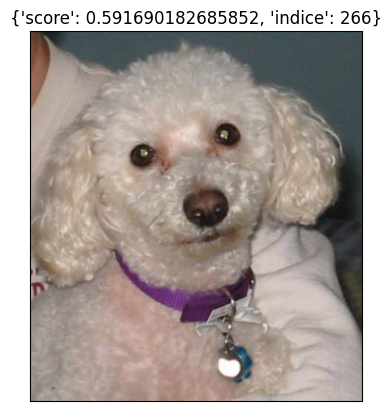

In [3]:
def get_test_transform():
    return T.Compose([
        T.Resize([320, 320]),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

image = Image.open("dog.png") # 289
img = get_test_transform()(image)
img = img.unsqueeze_(0) 
output = net(img)
score, indice = torch.max(torch.softmax(output,axis=-1),1)
info = {'score':score.tolist()[0],'indice':indice.tolist()[0]}

def show_image(image, title):
    import matplotlib.pyplot as plt 
    ax=plt.subplot()
    ax.imshow(image)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([]) 
    plt.show()

show_image(image, title = info)

## 二，pytorch模型转换成onnx模型



### 1， 简化版本

In [4]:
import onnxruntime
import onnx

batch_size = 1  
input_shape = (3, 320, 320)   

x = torch.randn(batch_size, *input_shape)
onnx_file = "resnet18.onnx"
torch.onnx.export(net,x,onnx_file,
                opset_version=10,
                do_constant_folding=True,	# 是否执行常量折叠优化
                input_names=["input"],
                output_names=["output"],
                dynamic_axes={
                    "input":{0:"batch_size"},  
                     "output":{0:"batch_size"}})


In [5]:
!du -s -h resnet18.pt 

 45M	resnet18.pt


In [6]:
!du -s -h resnet18.onnx 

 45M	resnet18.onnx


可以在 https://netron.app/ 中拖入 resnet18.onnx 文件查看模型结构

### 2，全面版本

下面的代码包括了设置输入输出尺寸，以及动态可以变batch等等。

In [7]:
import argparse
from argparse import Namespace
import time
import sys
import os
import torch
import torch.nn as nn
import torchvision.models as models
import onnx
import onnxruntime

from io import BytesIO


ROOT = os.getcwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

params = Namespace(weights='resnet18.pt',
                   img_size=[320,320],
                   batch_size=1,
                   half=False,
                   dynamic_batch=True
                  )

parser = argparse.ArgumentParser()
parser.add_argument('--weights', type=str, default='checkpoint.pt', help='weights path')
parser.add_argument('--img-size', nargs='+', type=int, default=[320, 320], help='image size')  # height, width
parser.add_argument('--batch-size', type=int, default=1, help='batch size')
parser.add_argument('--half', action='store_true', help='FP16 half-precision export')
parser.add_argument('--inplace', action='store_true', help='set Detect() inplace=True')
parser.add_argument('--simplify', action='store_true', help='simplify onnx model')
parser.add_argument('--dynamic-batch', action='store_true', help='export dynamic batch onnx model')
parser.add_argument('--trt-version', type=int, default=8, help='tensorrt version')
parser.add_argument('--device', default='cpu', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')

args = parser.parse_args(args='',namespace=params)


args.img_size *= 2 if len(args.img_size) == 1 else 1  # expand
print(args)

t = time.time()

# Check device
cuda = args.device != 'cpu' and torch.cuda.is_available()
device = torch.device(f'cuda:{args.device}' if cuda else 'cpu')
assert not (device.type == 'cpu' and args.half), '--half only compatible with GPU export, i.e. use --device 0'

# Load PyTorch model
model = create_net()
model.to(device)
model.load_state_dict(torch.load(args.weights)) # pytorch模型加载

# Input
img = torch.zeros(args.batch_size, 3, *args.img_size).to(device)  # image size(1,3,320,192) iDetection

# Update model
if args.half:
    img, model = img.half(), model.half()  # to FP16
model.eval()

prediction = model(img)  # dry run

# ONNX export
print('\nStarting to export ONNX...')
export_file = args.weights.replace('.pt', '.onnx')  # filename
with BytesIO() as f:
    dynamic_axes = {"input":{0:"batch_size"}, "output":{0:"batch_size"} } if args.dynamic_batch else None
    torch.onnx.export(model, img, f, verbose=False, opset_version=13,
                      training=torch.onnx.TrainingMode.EVAL,
                      do_constant_folding=True,
                      input_names=['input'],
                      output_names=['output'],
                      dynamic_axes=dynamic_axes)
    f.seek(0)
    # Checks
    onnx_model = onnx.load(f)  # load onnx model
    onnx.checker.check_model(onnx_model)  # check onnx model
    
if args.simplify:
    try:
        import onnxsim
        print('\nStarting to simplify ONNX...')
        onnx_model, check = onnxsim.simplify(onnx_model)
        assert check, 'assert check failed'
    except Exception as e:
        print(f'Simplifier failure: {e}')

onnx.save(onnx_model, export_file)

print(f'ONNX export success, saved as {export_file}')

# Finish
print('\nExport complete (%.2fs)' % (time.time() - t))



Namespace(weights='resnet18.pt', img_size=[320, 320], batch_size=1, half=False, dynamic_batch=True, inplace=False, simplify=False, trt_version=8, device='cpu')

Starting to export ONNX...
ONNX export success, saved as resnet18.onnx

Export complete (0.57s)


## 三，使用onnx模型进行推理

### 1，函数风格

In [8]:
onnx_sesstion = onnxruntime.InferenceSession(export_file)

In [9]:
def pipe(img_path,
         onnx_sesstion = onnx_sesstion):
    image = Image.open(img_path) 
    img = get_test_transform()(image)
    img = img.unsqueeze_(0) 

    to_numpy = lambda tensor: tensor.data.cpu().numpy()
    
    inputs = {onnx_sesstion.get_inputs()[0].name: to_numpy(img)}
    outs = onnx_sesstion.run(None, inputs)[0]

    score, indice = torch.max(torch.softmax(torch.as_tensor(outs),axis=-1),1)
    info = {'score':score.tolist()[0],'indice':indice.tolist()[0]}
    return info

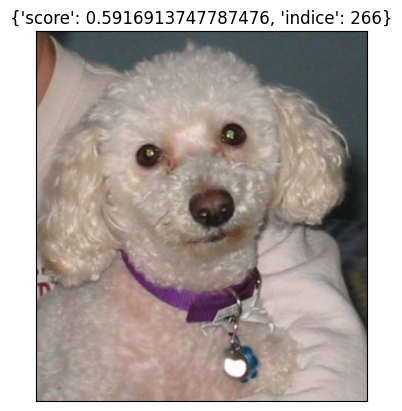

In [12]:
img_path = 'dog.png'
image = Image.open(img_path)
info = pipe(img_path)
show_image(image,info)

### 2，对象风格

In [13]:
import os, sys

import onnxruntime
import onnx
    
class ONNXModel():
    def __init__(self, onnx_path):
        self.onnx_session = onnxruntime.InferenceSession(onnx_path)
        self.input_names = [node.name for node in self.onnx_session.get_inputs()]
        self.output_names = [node.name for node in self.onnx_session.get_outputs()]
        print("input_name:{}".format(self.input_names))
        print("output_name:{}".format(self.output_names))
 
    def forward(self, x):
        if isinstance(x,np.ndarray):
            assert len(self.input_names)==1
            input_feed = {self.input_names[0]:x}
        elif isinstance(x,(tuple,list)):
            assert len(self.input_names)==len(x)
            input_feed = {k:v for k,v in zip(self.input_names,x)}
        else:
            assert isinstance(x,dict)
            input_feed = x
        outs = self.onnx_session.run(self.output_names, input_feed=input_feed)
        return outs
    
    def predict(self,img_path):
        image = Image.open(img_path) 
        img = get_test_transform()(image)
        img = img.unsqueeze_(0) 
        to_numpy = lambda tensor: tensor.data.cpu().numpy()
        outs = self.forward(to_numpy(img))[0]
        score, indice = torch.max(torch.softmax(torch.as_tensor(outs),axis=-1),1)
        return {'score':score[0].data.numpy().tolist(),
            'indice':indice[0].data.numpy().tolist()}
    

input_name:['input']
output_name:['output']


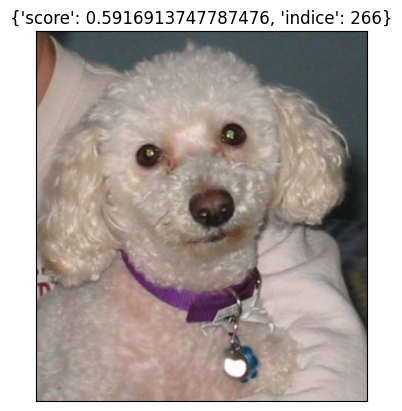

In [14]:
onnx_model = ONNXModel(export_file)
info = onnx_model.predict(img_path)
show_image(image, title = info)